In [1]:
from scripts.interactive_search import *
import networkx as nx
import numpy as np
from networkx.algorithms import community
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from NLP.tokenizer import clean_and_tokenize

In [2]:
# Change this function to select a different paper set
def read_metadata(path):
    df = pd.read_csv(path)
    df = df.astype({'abstract': 'str'})
    df = df[df['abstract'] != 'Unknown']
    df = df[df['abstract'] != 'nan']
    df = df[df['language'] == 'en']
    df = df[df['publish_time'].str[:4] == '2020']
    df = df.drop_duplicates(['title','abstract'])
    df = df.reset_index(drop=True)
    #df = df[:5000]
    return df

In [3]:
load_from_pickle = True
#EMBEDDINGS_PATH = 'data/embeddings_top5k.pkl'
EMBEDDINGS_PATH = 'data/embeddings_2020.pkl'
#METADATA_PATH = 'data/metadata_new_new.csv'
METADATA_PATH = 'data/metadata_en_20_topics.csv'

df_meta = read_metadata(METADATA_PATH)
abstracts = [a for a in df_meta['abstract']]
titles = df_meta['title'].reset_index(drop=True)

if load_from_pickle:
    with open(EMBEDDINGS_PATH, 'rb') as file:
        embeddings = pickle.load(file)

else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(abstracts, show_progress_bar=True)
    with open(EMBEDDINGS_PATH, 'wb') as file:
        pickle.dump(embeddings, file)

In [4]:
X = np.asarray(embeddings)

In [5]:
X.shape

(2702, 768)

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from mpl_toolkits.mplot3d import Axes3D

# This cell can take a few minutes to run
run_this_cell = False
n_clusters = 8

if run_this_cell:
    # In 2d
    methods = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in methods:
        X_embedded = embedding.fit_transform(X)
        fig = plt.figure()
        kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
        y_pred = kmeans.predict(X_embedded)
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_pred)
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    methods = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in methods:
        X_embedded = embedding.fit_transform(X)
        fig = plt.figure()
        ax = Axes3D(fig)
        kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
        y_pred = kmeans.predict(X_embedded)
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y_pred)
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In [7]:
def compute_clusters_spacial(X, method='pca', dim=2, n_clusters=8):
    clusters = []
    for i in range(n_clusters):
        clusters.append(set())
        
    if method == 'pca':
        algo = PCA(n_components=dim, copy=True, whiten=True, tol=1e-5)
    elif method == 'isomap':
        algo = Isomap(n_components=dim, n_neighbors=5)
    elif method == 'tsne':
        algo = TSNE(n_components=dim)
    else:
        print("Unknown embedding method")
    
    X_embedded = algo.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters).fit(X_embedded)
    classes = kmeans.predict(X_embedded)
    for i in range(len(classes)):
        clusters[classes[i]].add(titles[i])
        
    return clusters

In [8]:
def compute_adjacency(embeddings, epsilon):
    cosine_distances = scipy.spatial.distance.cdist(embeddings, embeddings, "cosine")
    cosine_similarities = 1 - cosine_distances
    cosine_similarities[cosine_similarities < epsilon] = 0
    np.fill_diagonal(cosine_similarities, 0.0)
    return cosine_similarities

In [9]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # We apply the formulas from the lecture
    D = np.diag(np.sum(adjacency, axis=0))
    L = D - adjacency
    if normalize: 
        D2 = np.diag(np.sum(adjacency, axis=0) ** (-1/2))
        Ln = np.dot(np.dot(D2, L), D2)
        return Ln
    else:
        return L

In [10]:
epsilon = 0.85
adjacency = compute_adjacency(embeddings, epsilon)

In [11]:
print("Non-zero weight percentage: " + '{0:.2f}'.format(adjacency[adjacency!=0].size * 100 / adjacency.size) + '%')

Non-zero weight percentage: 2.07%


In [12]:
G = nx.from_numpy_array(adjacency)
print("Number of connected components: " + repr(nx.number_connected_components(G)))

Number of connected components: 948


In [13]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [14]:
subgraphs = sorted(list(connected_component_subgraphs(G)), key=len, reverse=True) # Use this for version 2.4+ of networkx

In [15]:
G = subgraphs[0]  # Keep only the main connected component

In [16]:
adjacency = np.asarray(nx.to_numpy_matrix(G))

In [17]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

In [18]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    e_values, e_vectors = np.linalg.eigh(laplacian)

    return e_values, e_vectors.T # We transpose the eigenvectors so that e_vectors[k] is the k-th eigenvector (instead of e_vectors[:, k])

In [19]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

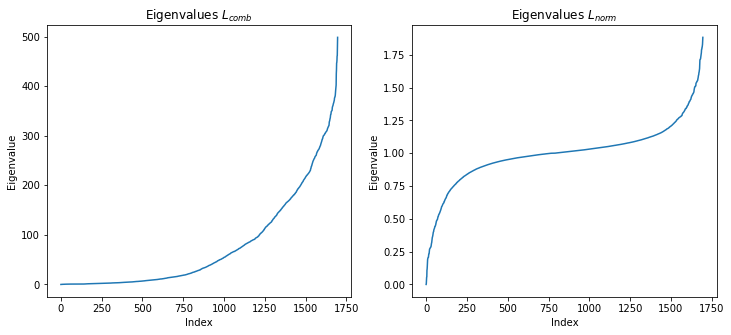

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [21]:
new_labels = {}
for i in list(G.nodes):
    new_labels.update({i: titles[i]})

In [22]:
G = nx.relabel.relabel_nodes(G, new_labels)

In [23]:
def compute_clusters_girvan(G, iterations):
    generator = community.centrality.girvan_newman(G)
    for i in range(0, iterations):
        print("Computing clusters, iteration " + repr(i+1) + '/' + repr(iterations), end='\r')
        clusters = next(generator)
    return clusters

In [24]:
def compute_clusters_fluid(G):
    clusters = []
    iterator = community.asyn_fluidc(G, 10, max_iter=1)
    for cluster in iterator:
        clusters.append(cluster)
    return clusters

In [25]:
def compute_clusters_lpa(G):
    clusters = []
    iterator = community.asyn_lpa_communities(G, 'weight')
    for cluster in iterator:
        clusters.append(cluster)
    return clusters

In [26]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\val\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop_words = set(stopwords.words('english'))
stop_words.add('coronavirus')
stop_words.add('virus')
stop_words.add('novel')
stop_words.add('chapter')

In [33]:
#clusters = compute_clusters_lpa(G)
#clusters = compute_clusters_fluid(G)  # Works quite well with high epsilon (.85) and only keeping main connected component
clusters = compute_clusters_spacial(X, method='pca', dim=3, n_clusters=4)
#clusters = compute_clusters_girvan(G, 30)
for cluster in clusters:
    print(len(cluster))

544
739
617
775


In [34]:
min_community_size = 6
top_k = 10

for cluster in clusters:
    if len(cluster) < min_community_size:
        continue
    word_count = {}
    for title in cluster:
        if type(title) != str:
            print("Error: title is not a string => " + repr(title))
        tokens = clean_and_tokenize(title)
        for token in tokens:
            if token in stop_words:
                continue
            if token in word_count.keys():
                word_count[token] += 1
            else:
                word_count[token] = 1
    print(sorted(word_count, key=word_count.get, reverse=True)[:top_k])
    print(sorted(word_count.values(), reverse=True)[:top_k])

['covid-19', 'disease', 'health', 'infection', 'control', 'viral', 'respiratory', 'epidemic', 'outbreak', 'analysis']
[82, 43, 36, 35, 29, 29, 29, 28, 28, 27]
['covid-19', '2019', 'china', 'sars-cov-2', 'disease', 'outbreak', '2019-ncov', 'epidemic', 'pneumonia', 'infection']
[267, 146, 118, 113, 99, 98, 85, 80, 73, 72]
['covid-19', 'disease', '2019', 'sars-cov-2', 'china', 'infection', 'outbreak', '2019-ncov', 'epidemic', 'pneumonia']
[133, 70, 61, 56, 55, 52, 47, 40, 38, 36]
['covid-19', '2019', 'clinical', 'china', 'patients', 'disease', 'pneumonia', 'characteristics', 'infection', 'outbreak']
[302, 155, 140, 135, 115, 108, 107, 78, 76, 75]


In [30]:
nx.write_gexf(G, "data/graph.gexf")